# 第十三课 物理模拟

其实我们在第二节课的时候，就已经进行了简单的物理模拟。

但是第二节课的例子，我们还是在处理“孤体问题”，即知道一个系统的完整动力学状态，推测一个系统的未来演化。

在三体运动这些例子里，都没有出现明显的碰撞等现象。但是现实过程中，物体很容易相互之间发生碰撞，从而产生复杂的行为。

而计算机正擅长模拟这些复杂的行为，很多时候可以给物理学家提供很多有用的帮助。

## 杯中的珠子

我们之前有个学生项目，是建模沙漏漏完的时间和沙漏角度、高度等变量之间的关系。

这个模型有一些复杂，让我们来做一个相对更简单的例子。

我们假设一个二维的杯子，我们向这个杯子里面不停地放半径相同的圆形。我们想知道整体珠子高度（最高一颗珠子的圆心）和珠子颗数的关系。

下面我们来开始编写编程的prompt

---

在一个宽度为100，高300的二维杯子里，不停放入半径为8的圆形小球。圆形小球和杯子之间发生完全非弹性碰撞

我想记录放入小球个数和最高的那个小球的圆心之间的关系。并可视化到散点图。

请用python为我实现。

---

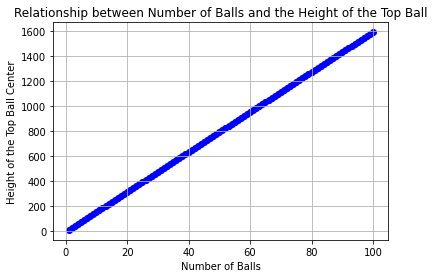

In [1]:
import matplotlib.pyplot as plt

def simulate_balls(cup_width, ball_radius, max_balls):
    positions = []  # List to store the positions of the balls (x, y)
    heights = []  # List to store the heights of each ball added
    
    def find_position(new_radius):
        # Function to find the correct position for the new ball
        for x in range(0, cup_width, 2*new_radius):
            y = new_radius  # start with the radius (ball sitting on the cup's bottom)
            for (existing_x, existing_y) in positions:
                # Check if the new ball overlaps vertically with an existing ball
                distance = ((existing_x - x)**2 + (existing_y - y)**2)**0.5
                if distance < 2 * new_radius:
                    # Move the new ball on top of the existing one if overlapping
                    y = max(y, existing_y + 2 * new_radius)
            if x + new_radius <= cup_width:
                return x, y
        return None  # No valid position found within the cup width

    for _ in range(max_balls):
        pos = find_position(ball_radius)
        if pos is None:
            break  # Stop if no position is found
        positions.append(pos)
        heights.append(pos[1])  # Store the height of each ball's center

    return heights

# Parameters
cup_width = 100
ball_radius = 8
max_balls = 100

# Simulate
heights = simulate_balls(cup_width, ball_radius, max_balls)

# Plot
plt.scatter(range(1, len(heights) + 1), heights, color='blue')
plt.title('Relationship between Number of Balls and the Height of the Top Ball')
plt.xlabel('Number of Balls')
plt.ylabel('Height of the Top Ball Center')
plt.grid(True)
plt.show()


当然这样我们也无法验证这个程序是不是对的

其实很有可能是错的，那怎么办呢？ 我们可以用更动态的方法来进行模拟。

我们使用一个叫做pymunk的物理模拟引擎。

---

我希望实现一个pymunk的物理模拟程序

先定义一个宽度为100，高度为300的二维杯子（上方开口，用三面刚性的墙壁来定义这个杯子）

定义radius = 8

初始化highest_ball 为 杯底高度

依次放入50颗小球，每次放入小球后，允许小球运动一段短的时间，并更新 highest_ball

然后在highest_ball + 5 * radius的地方放置一个新的小球

小球之间以及小球和杯子之间发生完全非弹性碰撞

记录每个小球的序号

在结束的时候，按顺序输出每个小球的圆心高度到excel表格

---

我发现这个prompt似乎有一些复杂了，那让我们把任务分解一下

- 先用pymunk写一个交互模拟数据
- 再记录数字

```
我希望实现一个pymunk的物理模拟程序

先定义一个宽度为100，高度为height = 300的二维杯子（上方开口，用三面刚性的墙壁来定义这个杯子）

我希望每次空格按下的时候，在杯口位置渲染一个小球落下
```


ChatGLM 第一次给我写的程序有一些小错误，这个代码在 pygame_codes/13_wrong_direction.py 中

有两个明显的错误，一是重力方向是反的。二是我们需要杯口是向上的

所以我们让他修改一下程序

```
这段程序可以顺利运行，但是重力方向是反的，

同时，杯口是向下的，需要把横边渲染到杯底
```

我们在第二次修改后，还是没有得到正确的代码

这个时候我们只能手工修改一下，这里我们在 pygame_codes/13_fix_wrong_direction.py 中，手工修改了两处代码，程序显得可以正常运行了

观察这个程序一共有三个部分

初始化部分

In [ ]:
import pymunk
import pygame
import sys

# 初始化pygame
pygame.init()

# 设置屏幕大小
width, height = 600, 400
screen = pygame.display.set_mode((width, height))

# 设置时钟
clock = pygame.time.Clock()

# 创建一个空间
space = pymunk.Space()
# space.gravity = (0, 981)  # 设置重力，向下
# 手工修改
space.gravity = (0, - 981)  # 设置重力，向下


# 杯子的尺寸
cup_width = 100
cup_height = 300
cup_x = 50  # 杯子左侧的x坐标
cup_y = height - 50  # 杯子底部的y坐标

# 创建杯子的墙壁
static_lines = [
    pymunk.Segment(space.static_body, (cup_x, cup_y), (cup_x, cup_y - cup_height), 5),
    pymunk.Segment(space.static_body, (cup_x, cup_y - cup_height), (cup_x + cup_width, cup_y - cup_height), 5),
    pymunk.Segment(space.static_body, (cup_x + cup_width, cup_y - cup_height), (cup_x + cup_width, cup_y), 5)
]

for line in static_lines:
    line.elasticity = 0.5
    line.friction = 0.5
    space.add(line)

渲染部分

In [ ]:
# 渲染函数
def draw(space):
    screen.fill((255, 255, 255))
    
    # 绘制墙壁
    for line in static_lines:
        body = line.body
        pv1 = body.position + line.a.rotated(body.angle)
        pv2 = body.position + line.b.rotated(body.angle)
        p1 = to_pygame(pv1)
        p2 = to_pygame(pv2)
        pygame.draw.lines(screen, (0, 0, 0), False, [p1, p2])

    # 绘制小球
    for ball in balls:
        pos = ball.body.position
        pygame.draw.circle(screen, (0, 0, 255), to_pygame(pos), int(ball.radius), 2)

    pygame.display.flip()


生成和控制部分

In [ ]:

# 将pymunk坐标转换为pygame坐标
def to_pygame(p):
    return int(p.x), int(-p.y + height)

# 主循环
balls = []
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
            # 在杯口位置添加小球
            mass = 10
            radius = 10
            moment = pymunk.moment_for_circle(mass, 0, radius)
            body = pymunk.Body(mass, moment)
            # body.position = cup_x + cup_width / 2, cup_y - cup_height
            # 手工修改
            body.position = cup_x + cup_width / 2, cup_y
            shape = pymunk.Circle(body, radius)
            shape.elasticity = 0.5
            space.add(body, shape)
            balls.append(shape)

    # 模拟
    space.step(1/50.0)
    
    # 渲染
    draw(space)
    
    # 控制帧率
    clock.tick(50)

pygame.quit()
sys.exit()


这里我们要注意到pymunk的坐标系和pygame的坐标系有所不同

这里ChatGLM使用了一个to_pygame进行转换

这个不同也是ChatGPT们都写不好这个程序的原因

这里我们进一步把这个程序修改

- 把球的x位置改为从radius到杯子宽度-radius之间随机生成
- 注意到之前的程序小球半径并不是8，重新修改为8

修改后的程序在pygame_codes/13_random_x_position.py，已经能够较好的实现我们的第一步。

【这里补一张截图】

我们的下一步，就是增加记录小球位置的功能。

---

{贴上pygame_codes/13_random_x_position.py的代码}

这段代码可以顺利运行

我希望每次引入新小球的时候，把之前所有小球的位置（记住小球的顺序）

更新保存到一个list of tuple中，（记住每次按下空格的时候都会更新之前所有小球的位置）

并且当按下s键时，帮我把小球的序号、y 存储到data/ball_heights.csv中

我们发现这批数据是从62.8左右开始的。这是由于杯子的地步是渲染在大致50的位置，并且杯壁其实有5像素左右的厚度。

55加上半径8，就是63了

我们想看看，随着小球数量的变多，最高的那个小球的中心位置，是什么样一个关系

----

data/ball_heights.csv存储的数据如下

Ball Index,Y Position
0,62.90499694130368
1,62.837123886492954
2,62.73808217542311
3,62.87287239268411

请用线性拟合，拟合y和球数量之间的关系，用plt画出对应的可视化，并告诉我斜率



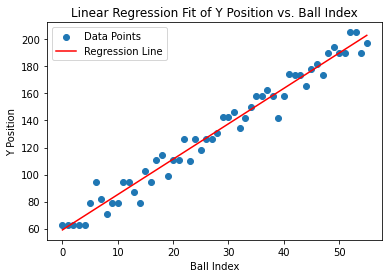

斜率是 2.6178376808391057


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV data
# file_path = '/mnt/data/ball_heights.csv'
# 修改文件路径
file_path = 'data/ball_heights.csv'
data = pd.read_csv(file_path)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(data['Ball Index'], data['Y Position'])

# Create a range of x values for plotting the regression line
x_regression = np.linspace(min(data['Ball Index']), max(data['Ball Index']), 100)

# Calculate the y values for the regression line
y_regression = slope * x_regression + intercept

# Plot the original data points
plt.scatter(data['Ball Index'], data['Y Position'], label='Data Points')

# Plot the regression line
plt.plot(x_regression, y_regression, color='red', label='Regression Line')

# Add labels and title
plt.xlabel('Ball Index')
plt.ylabel('Y Position')
plt.title('Linear Regression Fit of Y Position vs. Ball Index')

# Show the plot
plt.legend()
plt.show()

print("斜率是", slope)


也就是说，每增加一个小球，高度会增加2.618左右

事实上，我们可以用简单的建模来考虑这个高度增加

最简单的情况下，我们可以假设小球是一个“液滴”，

那样一个小球会增加pi radius^2的面积，这些面积会全部分布在宽度100的杯子中，所以这个时候我们计算出的一个理论斜率下界是

In [2]:
radius = 8
from math import pi

# 计算理论斜率下界
slope_lower_bound = pi * radius**2 / 100

print("理论斜率下界是", slope_lower_bound)

理论斜率下界是 2.0106192982974678


因为小球有空隙，所以实际斜率肯定比这个理论斜率要高一些。

更进一步，我们假设小球是蜂窝状密堆的，这样可以计算出一个更紧凑的密堆下界

即密堆时，总面积闭上小球的实际面积，等于

边长为16的一个正三角形，比上半圆的面积，这个面积比是

In [5]:
from math import sqrt
print(8*8*sqrt(3) / (8*8*pi/2) )

1.1026577908435842


我们拿这个系数去修正之前的液体估计的下界，得到新的下界是

In [6]:
a = 8*8*sqrt(3) / (8*8*pi/2) 
slope_lower_bound = pi * radius**2 / 100
new_bound = slope_lower_bound * a
print("新的下界是", new_bound)


新的下界是 2.2170250336881634


这个新的下界已经比之前要更接近2.6178了，由于小球在桶内并没办法实现真正的二维密堆，所以真实的系数总是要比密堆的理论下界要更高一些。

## 课堂练习

- 修改代码，看看不同的半径、不同杯壁大小影响下。模拟的数据有什么不同

## 小结

可以注意到这节课我们先使用了pymunk进行物理模拟

然后对模拟的数据，使用了上节课学习的机器学习工具来进行回归。并且得到了一个实际模型中的某个系数

